# Libraries

In [20]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import numpy as np
import argparse
import time
import os
import imageio
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import math

# OTSU Threshold (Max)

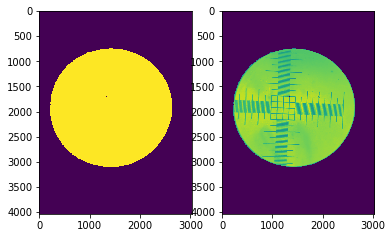

In [10]:
img = imageio.imread('Images/IMG_1716.JPG')
img_gray = rgb2gray(img)

th = threshold_otsu(img_gray)

# create and plot image 
fig, ax = plt.subplots(1, 2)

fg = img_gray>th
ax[0].imshow(fg)
ax[1].imshow(img_gray*fg)

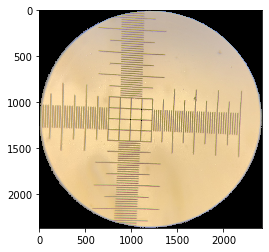

In [11]:
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)
plt.show()

In [27]:

# area of circle A = πr^2
print((img_cropped.shape[1] / 2)** 2 * math.pi)

#area of image around 12 MP
print(img.shape[0] * img.shape[1])

# lost area in percent
print( 100 - ((img_cropped.shape[1] / 2)** 2 * math.pi) / (img.shape[0] * img.shape[1]) * 100)

4603407.916629823
12192768
62.244767417621475


In [12]:
# Circle detection (not robust enough)

In [27]:
def get_circles(img):
    img = (img * 255).astype("uint8")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ

    blurred_mask = cv2.blur(gray, (80, 80)) 

    
#    print(np.average(blurred_mask))
    thresh, maxValue = 100, 256
    th, dst = cv2.threshold(blurred_mask, thresh, maxValue, cv2.THRESH_BINARY)
    
    detected_circles = cv2.HoughCircles(dst,  
                cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30, minRadius = 0, maxRadius = 0) 
    return detected_circles, dst, blurred_mask #, np.average(img), np.average(blurred_mask)

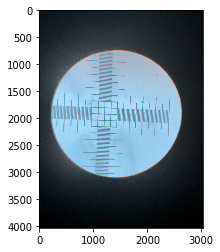

In [28]:
img = cv2.imread('Images/IMG_1716.JPG', cv2.IMREAD_COLOR)
plt.imshow(img)

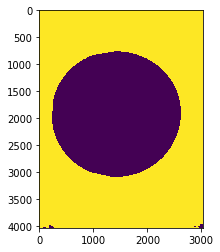

In [29]:
detected_circles, dst, blurred_mask = get_circles(img)
plt.imshow(dst)

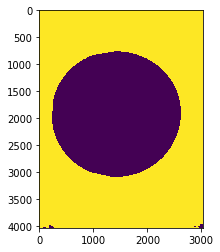

In [30]:
plt.imshow(dst)

In [31]:
detected_circles

In [32]:
circles = img.copy()

# Draw circles that are detected. 
if detected_circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    detected_circles = np.uint16(np.around(detected_circles)) 
  
    for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
        # Draw the circumference of the circle. 
        cv2.circle(circles, (a, b), r, (0, 0, 255), 2) 
        print('a: ' + str(a) + ' b: ' + str(b))
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(circles, (a, b), 1, (255, 0, 0), 3) 

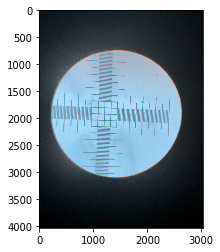

In [33]:
plt.imshow(circles)

# Grab cut (possibly too slow)

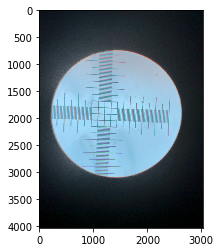

In [2]:
# load the input image and associated mask from disk
image = cv2.imread('Images/IMG_1716.JPG')
mask = cv2.imread('Images/IMG_1716.JPG', cv2.IMREAD_GRAYSCALE)
# apply a bitwise mask to show what the rough, approximate mask would
# give us
roughOutput = cv2.bitwise_and(image, image, mask=mask)
# show the rough, approximated output
plt.imshow(roughOutput)

In [11]:
# any mask values greater than zero should be set to probable
# foreground
mask[mask > 80] = cv2.GC_PR_FGD
mask[mask == 0] = cv2.GC_BGD

In [12]:
# allocate memory for two arrays that the GrabCut algorithm internally
# uses when segmenting the foreground from the background
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
# apply GrabCut using the the mask segmentation method
start = time.time()
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, None, bgModel,
	fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_MASK)
end = time.time()
print("[INFO] applying GrabCut took {:.2f} seconds".format(end - start))

[INFO] applying GrabCut took 143.50 seconds


In [13]:
# set all definite background and probable background pixels to 0
# while definite foreground and probable foreground pixels are set
# to 1, then scale teh mask from the range [0, 1] to [0, 255]
outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),0, 1)
outputMask = (outputMask * 255).astype("uint8")
# apply a bitwise AND to the image using our mask generated by
# GrabCut to generate our final output image
output = cv2.bitwise_and(image, image, mask=outputMask)

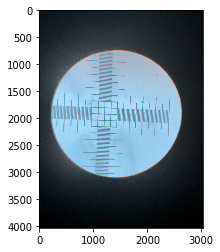

In [14]:
# show the input image followed by the mask and output generated by
# GrabCut and bitwise masking
plt.imshow(image)

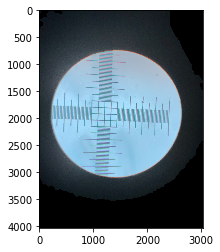

In [15]:
plt.imshow(output)

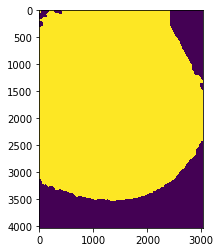

In [16]:
plt.imshow(outputMask)


# Contours